In [103]:
!pip install aimodelshare

## **Part 1: Build a classification model using text data**

In part one of the homework, you will solve a text classification task.

The data consists of headlines that signify clickbait or not.  Training and test data are stored in the following objects: X_train, X_test, y_train_labels, y_test_labels.  The remaining objects can be ignored.

In a real application this might allow us to find out what is hard news information (or perhaps to choose among headlines that are more likely to be clicked).

Use cross-validation to evaluate the results. Use a robust metric for classification  (AUC or F1-Score for example), and inspect all models by visualizing the coefficients. (See helper function in our in class notebook for text models.)

To complete part one of the homework do the following:

**Import the text data, vectorize the clickbait headline column into an X matrix.  Then run logistic regression at least three times and select a single best model.  Note that you should create three logistic regression models with different different tokenization approaches.  You should not change your modeling approach, you should simply experiment with different tokenizers. Be sure to explain your choices and evaluate your models using cross validation and using test set data.**

In [104]:
#Import data
import aimodelshare as ai
X_train, X_test, y_train_labels, y_test_labels, example_data, lstm_model, lstm_model2 = ai.import_quickstart_data("clickbait")


Data downloaded successfully.

Preparing downloaded files for use...

Success! Your Quick Start materials have been downloaded. 
You are now ready to run the tutorial.


In [105]:
print(X_train.head())

0       MyBook Disk Drive Handles Lots of Easy Backups
1                       CIT Posts Eighth Loss in a Row
2    Candy Carson Singing The "National Anthem" Is ...
3    Why You Need To Stop What You're Doing And Dat...
4    27 Times Adele Proved She's Actually The Reale...
Name: headline, dtype: object


In [106]:
print(y_train_labels.head())

13620    not clickbait
15394    not clickbait
2796         clickbait
1673         clickbait
13020        clickbait
Name: label, dtype: object


In [107]:
#Count vectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
X_vec = count.fit_transform(X_train)
X_test_vec = count.transform(X_test)

In [108]:
print(count.vocabulary_)

{'mybook': 12118, 'disk': 5391, 'drive': 5708, 'handles': 8231, 'lots': 10820, 'of': 12660, 'easy': 5880, 'backups': 1668, 'cit': 3619, 'posts': 13925, 'eighth': 5965, 'loss': 10815, 'in': 9123, 'row': 15606, 'candy': 3049, 'carson': 3163, 'singing': 16581, 'the': 18225, 'national': 12214, 'anthem': 1116, 'is': 9547, 'only': 12744, 'thing': 18258, 'you': 20213, 'need': 12264, 'today': 18441, 'why': 19870, 'to': 18431, 'stop': 17409, 'what': 19818, 're': 14696, 'doing': 5531, 'and': 1021, 'date': 4782, 'robot': 15482, '27': 197, 'times': 18391, 'adele': 603, 'proved': 14275, 'she': 16342, 'actually': 576, 'realest': 14721, 'celebrity': 3280, 'all': 876, '29': 203, 'blackgirlmagic': 2249, 'was': 19667, 'more': 11912, 'than': 18215, 'just': 9871, 'hashtag': 8326, '2015': 156, 'scientology': 15955, 'ties': 18358, 'at': 1433, 'new': 12334, 'village': 19447, 'leadership': 10415, 'academy': 481, 'stir': 17383, 'controversy': 4221, 'for': 7144, 'will': 19910, 'smith': 16784, 'jada': 9629, 'pin

In [109]:
#Perform logistic regression on training and test sets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

log = LogisticRegression()
log.fit(X_vec, y_train_labels)

y_pred = log.predict(X_test_vec)

print(confusion_matrix(y_test_labels, y_pred))
print(classification_report(y_test_labels, y_pred))

score = cross_val_score(LogisticRegression(), X_vec, y_train_labels, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(score)))

log.fit(X_test_vec, y_test_labels)
test_score = cross_val_score(LogisticRegression(), X_test_vec, y_test_labels, cv=5)
print("Mean test set cross-validation accuracy: {:.2f}".format(np.mean(test_score)))

[[2890  132]
 [  50 3173]]
               precision    recall  f1-score   support

    clickbait       0.98      0.96      0.97      3022
not clickbait       0.96      0.98      0.97      3223

     accuracy                           0.97      6245
    macro avg       0.97      0.97      0.97      6245
 weighted avg       0.97      0.97      0.97      6245

Mean cross-validation accuracy: 0.97
Mean test set cross-validation accuracy: 0.95


In [110]:
#GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid.fit(X_test_vec, y_test_labels)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.96
Best parameters:  {'C': 10}


In [111]:
#Plot top coefficients
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


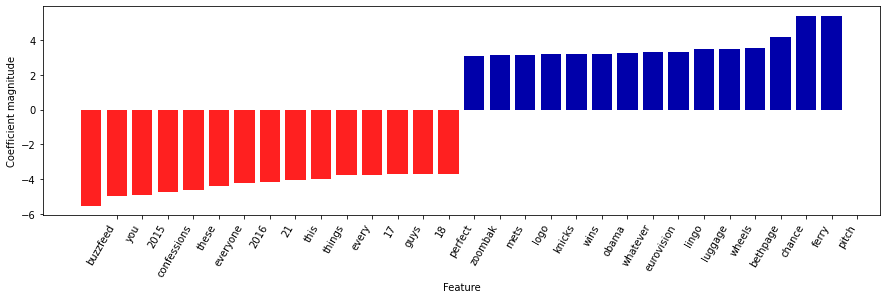

In [112]:
import matplotlib.pyplot as plt

coefs = LogisticRegression(C=10).fit(X_vec, y_train_labels).coef_
feature_names = count.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=15)

In [121]:
#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vtf = TfidfVectorizer(norm=None)
X_train_tf = vtf.fit_transform(X_train)
X_test_tf = vtf.transform(X_test)

y_pred_tf = log.predict(X_test_tf)

print(confusion_matrix(y_test_labels, y_pred_tf))
print(classification_report(y_test_labels, y_pred_tf))

[[3020    2]
 [  54 3169]]
               precision    recall  f1-score   support

    clickbait       0.98      1.00      0.99      3022
not clickbait       1.00      0.98      0.99      3223

     accuracy                           0.99      6245
    macro avg       0.99      0.99      0.99      6245
 weighted avg       0.99      0.99      0.99      6245



In [122]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid.fit(X_train_tf, y_train_labels)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

score_tf = cross_val_score(LogisticRegression(), X_train_tf, y_train_labels, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(score_tf)))

score_tf_test = cross_val_score(LogisticRegression(), X_test_tf, y_test_labels, cv=5)
print("Mean test set cross-validation accuracy: {:.2f}".format(np.mean(score_tf_test)))

Best cross-validation score: 0.97
Best parameters:  {'C': 0.1}
Mean cross-validation accuracy: 0.97
Mean test set cross-validation accuracy: 0.96


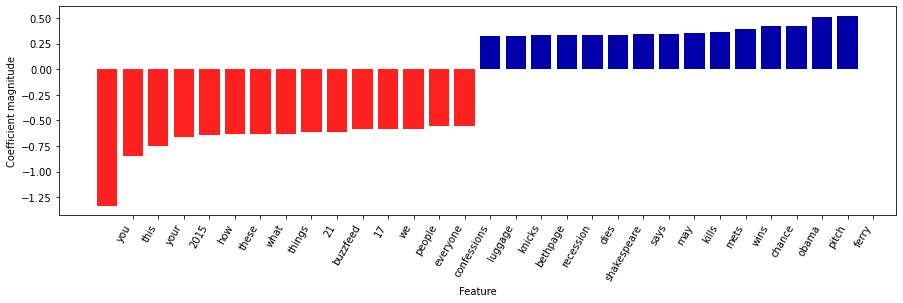

In [123]:
#Visualize coefficients
coefs_tf = LogisticRegression(C=0.1).fit(X_train_tf, y_train_labels).coef_
feature_names_tf = vtf.get_feature_names()

visualize_coefficients(coefs_tf, feature_names_tf, n_top_features=15)

In [147]:
#bi-grams
vbi = CountVectorizer(ngram_range=(2,2), min_df=5)
X_bi = vbi.fit_transform(X_train)
X_test_bi = vbi.transform(X_test)

score_bi = cross_val_score(LogisticRegression(), X_bi, y_train_labels, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(score_bi)))

log.fit(X_test_bi, y_test_labels)
test_score_bi = cross_val_score(LogisticRegression(), X_test_bi, y_test_labels, cv=5)
print("Mean test set cross-validation accuracy: {:.2f}".format(np.mean(test_score_bi)))

Mean cross-validation accuracy: 0.92
Mean test set cross-validation accuracy: 0.87


In [148]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5)
grid.fit(X_bi, y_train_labels)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

score_bi = cross_val_score(LogisticRegression(), X_train_tf, y_train_labels, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(score_bi)))

score_bi_test = cross_val_score(LogisticRegression(), X_test_tf, y_test_labels, cv=5)
print("Mean test set cross-validation accuracy: {:.2f}".format(np.mean(score_bi_test)))

Best cross-validation score: 0.93
Best parameters:  {'C': 10}
Mean cross-validation accuracy: 0.97
Mean test set cross-validation accuracy: 0.96


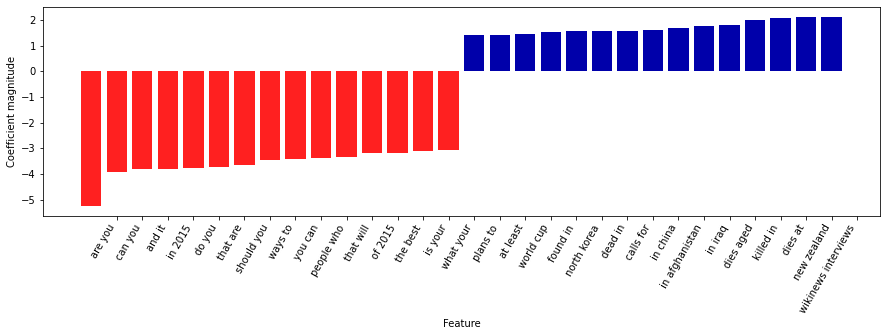

In [149]:
coefs_bi = LogisticRegression().fit(X_bi, y_train_labels).coef_
feature_names_bi = vbi.get_feature_names()

visualize_coefficients(coefs_bi, feature_names_bi, n_top_features=15)

The three types of tokenization methods I chose to use are Count Vectorizer for single words, Tf-idf vectorizer, and Count Vectorizer for bi-grams.<br>
The logistic regression model for the first single word count vectorizer resulted in a f1-score of 0.97 and a cross validation score of 0.95 for the test set. 
I chose the Tf-idf vectorizer to determine the rare terms that appear most frequently in clickbait headlines. The logistic regression model for the Tf-idf vectorizer resulted in a cross validation score of 0.97 and a f1-score of 0.99.
Next, I chose to look at bi-grams and tri-grams because clickbait titles tend to consist of 2 to 3 word phrases. The logistic regression model for the bi-grams and tri-grams count vectorizer resulted in a cross validation score of 0.92. <br>
I would choose the Tf-idf vectorizer model to determine and classify clickbait headlines based on it having the best cross validation score of 0.97 and f1-score of 0.99.



## Part 2: Build a predictive neural network using Keras

To complete part two of the homework do the following:

Run a multilayer perceptron (feed forward neural network) with two hidden layers on the iris dataset using the keras Sequential interface.

Data can be imported via the following link:

http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv

Include code for selecting the number of hidden units using GridSearchCV and evaluation on a test-set.  Describe the differences in the predictive accuracy of models with different numbers of hidden units.  Describe the predictive strength of your best model.  Be sure to explain your choice and evaluate this model using the test set.

In [150]:
#Import data
import pandas as pd
data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv", index_col=0)
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [151]:
#Set up data for train test split
y = data['Species']
X = data.loc[:, data.columns != 'Species']

print(X.shape)
print(y.shape)
print(X.head())
print(y.head())

(150, 4)
(150,)
   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
1           5.1          3.5           1.4          0.2
2           4.9          3.0           1.4          0.2
3           4.7          3.2           1.3          0.2
4           4.6          3.1           1.5          0.2
5           5.0          3.6           1.4          0.2
1    setosa
2    setosa
3    setosa
4    setosa
5    setosa
Name: Species, dtype: object


In [174]:
#Train test split and encode y into labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_labels = pd.get_dummies(y_train)
y_test_labels = pd.get_dummies(y_test)

print(X_train.shape)
print(y_train_labels.shape)
print(X_test.shape)
print(y_test_labels.shape)

(120, 4)
(120, 3)
(30, 4)
(30, 3)


In [175]:
#First model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier

model = Sequential([
        Dense(10, input_dim = 4),
        Activation('relu'),
        Dense(10),
        Activation('relu'),
        Dense(3),
        Activation('softmax')
    ])
        
model.compile(optimizer='sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_labels,
          epochs=20,
          batch_size=20)

print(model.summary())

score = model.evaluate(X_test, y_test_labels, batch_size=20)
print("Test Accuracy: {:.2f}".format(score[1]))

Epoch 1/20
6/6 [==============================] - 0s 3ms/step - loss: 1.4896 - accuracy: 0.3917
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 0.8662 - accuracy: 0.6667
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 0.8294 - accuracy: 0.6917
Epoch 4/20
6/6 [==============================] - 0s 2ms/step - loss: 0.7764 - accuracy: 0.6917
Epoch 5/20
6/6 [==============================] - 0s 3ms/step - loss: 0.7403 - accuracy: 0.7667
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 0.7182 - accuracy: 0.7250
Epoch 7/20
6/6 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.8167
Epoch 8/20
6/6 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.7333
Epoch 9/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.8000
Epoch 10/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.7750
Epoch 11/20
6/6 [======================

In [176]:
#Create model function and run GridSearchCV to determine best parameters

def make_model(optimizer='adam', hidden_nodes=10, learn_rate=0.01):
    model = Sequential([
        Dense(hidden_nodes, input_dim = 4),
        Activation('relu'),
        Dense(hidden_nodes),
        Activation('relu'),
        Dense(3),
        Activation('softmax')
    ])
        
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)

param_grid = {'epochs' : [20, 50, 100], 'hidden_nodes':  [10, 32, 64]}

grid = GridSearchCV(clf, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train_labels)

print(grid.best_params_)
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  app.launch_new_instance()


Streaming output truncated to the last 5000 lines.
Epoch 10/20
3/3 [==============================] - 0s 3ms/step - loss: 1.0146 - accuracy: 0.3438
Epoch 11/20
3/3 [==============================] - 0s 5ms/step - loss: 0.9651 - accuracy: 0.5312
Epoch 12/20
3/3 [==============================] - 0s 4ms/step - loss: 0.9175 - accuracy: 0.4479
Epoch 13/20
3/3 [==============================] - 0s 4ms/step - loss: 0.8855 - accuracy: 0.5729
Epoch 14/20
3/3 [==============================] - 0s 4ms/step - loss: 0.8509 - accuracy: 0.6562
Epoch 15/20
3/3 [==============================] - 0s 6ms/step - loss: 0.8194 - accuracy: 0.6667
Epoch 16/20
3/3 [==============================] - 0s 6ms/step - loss: 0.7927 - accuracy: 0.6667
Epoch 17/20
3/3 [==============================] - 0s 5ms/step - loss: 0.7637 - accuracy: 0.6667
Epoch 18/20
3/3 [==============================] - 0s 4ms/step - loss: 0.7392 - accuracy: 0.6667
Epoch 19/20
3/3 [==============================] - 0s 5ms/step - loss: 0.717

In [177]:
#Fit the model to train and test set
model = make_model(hidden_nodes=32)
model.fit(X_train, y_train_labels,
          epochs=100,
          batch_size=3)

print(model.summary())

score = model.evaluate(X_test, y_test_labels, batch_size=3, verbose=0)

#Display loss and accuracy score
print("\nTest loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Epoch 1/100
40/40 [==============================] - 0s 2ms/step - loss: 0.9439 - accuracy: 0.6250
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.7401 - accuracy: 0.6667
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.5945 - accuracy: 0.8167
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4936 - accuracy: 0.7917
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.8750
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3680 - accuracy: 0.9583
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3255 - accuracy: 0.9417
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3110 - accuracy: 0.8917
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2549 - accuracy: 0.9667
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9417
Epoch 11/

In [178]:
grid_result = grid.fit(X_test, y_test_labels)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Streaming output truncated to the last 5000 lines.
Epoch 10/20
1/1 [==============================] - 0s 4ms/step - loss: 1.0859 - accuracy: 0.6250
Epoch 11/20
1/1 [==============================] - 0s 5ms/step - loss: 1.0553 - accuracy: 0.6250
Epoch 12/20
1/1 [==============================] - 0s 6ms/step - loss: 1.0265 - accuracy: 0.6250
Epoch 13/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9996 - accuracy: 0.6250
Epoch 14/20
1/1 [==============================] - 0s 7ms/step - loss: 0.9747 - accuracy: 0.6250
Epoch 15/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9516 - accuracy: 0.6250
Epoch 16/20
1/1 [==============================] - 0s 4ms/step - loss: 0.9304 - accuracy: 0.6250
Epoch 17/20
1/1 [==============================] - 0s 5ms/step - loss: 0.9113 - accuracy: 0.6667
Epoch 18/20
1/1 [==============================] - 0s 7ms/step - loss: 0.8942 - accuracy: 0.7917
Epoch 19/20
1/1 [==============================] - 0s 4ms/step - loss: 0.879

Epoch 1/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9815 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0756 - accuracy: 0.9630 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 0.9722 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9630 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9537 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0792 - accuracy: 0.9722 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0786 - accuracy: 0.9722 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 8/50
36/36 [==

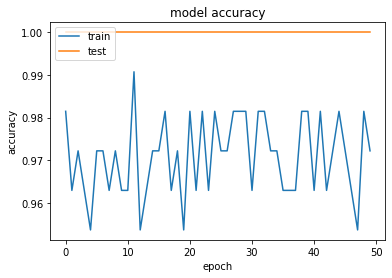

In [182]:
history = model.fit(X_train, y_train_labels, validation_split=0.1, epochs=50, batch_size=3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I first ran the model with randomly selected hidden nodes=10 and epoch=20, with optimizer SGD, which yielded an accuracy score of 0.87. After creating a make_model function and running GridSearchCV, the best parameters were determined to be epochs=100 and hidden nodes=32, using the Adam optimizer. This resulted in an accuracy score of 0.983, which significantly improved upon the previous model. However, as seen from the accuracy history plot, the training set scores seem to be highly inconsistent with chances of overfitting.